In [28]:
import xgboost
from catboost import CatBoostClassifier
import shap
import sklearn
# from sklearn import train_test_split
from sklearn import metrics

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [29]:
raw_data = ascii.read('../../data/raw/plti/kplr_dr25_inj1_plti.txt')
df = raw_data.to_pandas()
df.dropna()


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'Fit_Provenance' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


,KIC_ID,Sky_Group,i_period,i_epoch,N_Transit,i_depth,i_dur,i_b,i_ror,i_dor,...,TCE_ID,Measured_MES,r_period,r_epoch,r_depth,r_dur,r_b,r_ror,r_dor,Fit_Provenance
5,11601794,8,71.3789,111.5236,15.1325,838.0,3.88664,0.3761,0.0232,133.934,...,011601794-01,8.4883,71.3804,182.8861,710.0,4.07025,0.499,0.0250,119.969,1.0
24,11752906,8,70.8269,67.1199,15.3007,1482.0,4.90840,0.4186,0.0353,104.314,...,011752906-02,13.3271,70.8261,137.9486,1443.0,4.81873,0.452,0.0347,104.531,1.0
32,11852982,8,21.6441,85.7861,50.6752,327.0,3.14444,0.2744,0.0143,51.445,...,011852982-02,10.4557,21.6441,150.7203,277.0,3.23718,0.860,0.0176,27.822,1.0
33,11853130,8,70.9432,101.2425,16.1289,1588.0,4.03196,0.4033,0.0293,128.272,...,011853130-02,9.5943,70.9436,172.1771,1240.0,3.74120,0.278,0.0321,143.978,1.0
34,11854219,8,31.3363,96.2654,34.3284,793.0,2.46341,0.5632,0.0233,83.388,...,011854219-01,7.8305,31.3365,158.9426,560.0,2.03661,0.060,0.0217,119.888,1.0
49,12005016,8,24.4795,88.3795,44.1366,769.0,2.73537,0.4184,0.0216,63.989,...,012005016-01,9.1802,24.4794,137.3401,606.0,2.57098,0.387,0.0227,68.869,1.0
53,12102169,8,36.9909,74.6180,29.1442,675.0,3.82006,0.2903,0.0198,72.569,...,012102169-01,7.5921,36.9894,148.6431,410.0,4.66318,0.045,0.0183,61.652,1.0
59,6579884,31,14.5834,76.6400,97.8850,618.0,2.58885,0.3223,0.0189,41.748,...,006579884-01,10.4117,14.5833,134.9820,398.0,2.41102,0.239,0.0183,45.742,1.0
60,6580019,31,63.3769,66.9085,6.0810,67281.0,2.26440,0.1094,0.7066,262.313,...,006580019-01,22.0327,63.3794,193.6341,718134.0,2.00000,0.100,0.4369,347.023,0.0
63,6665209,31,71.6247,97.1001,4.9041,230091.0,3.15378,0.2762,1.4799,246.570,...,006665209-01,53.1559,71.6226,168.7424,2348548.0,2.00000,0.100,0.5000,409.455,0.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

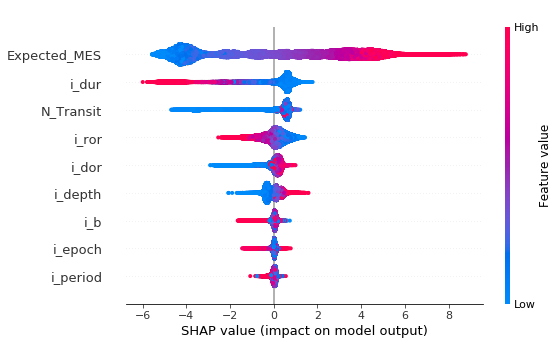

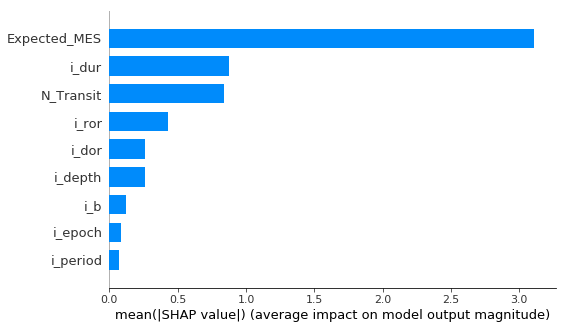

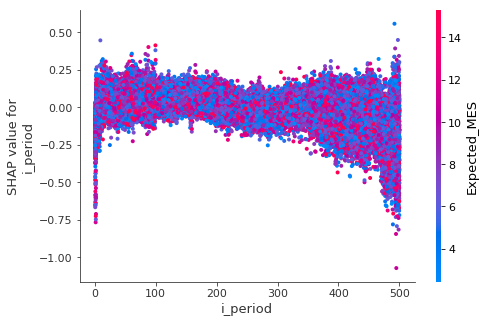

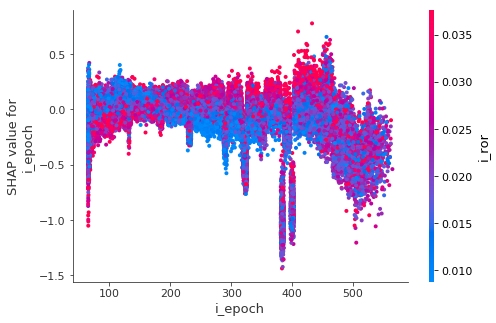

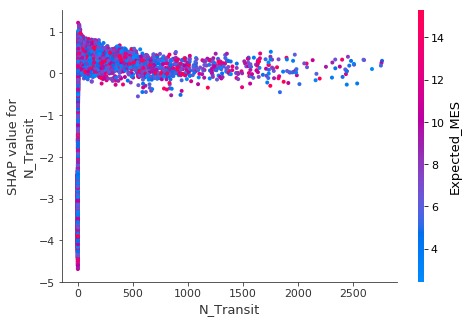

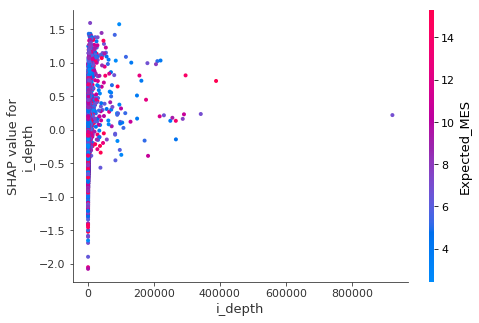

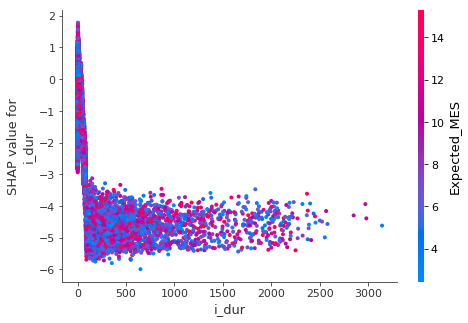

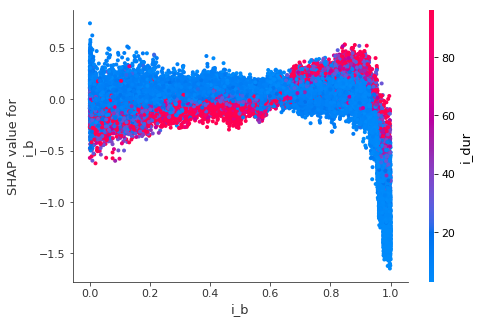

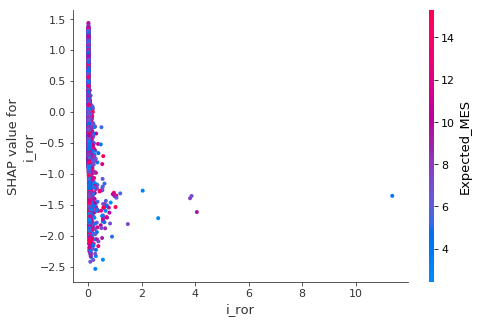

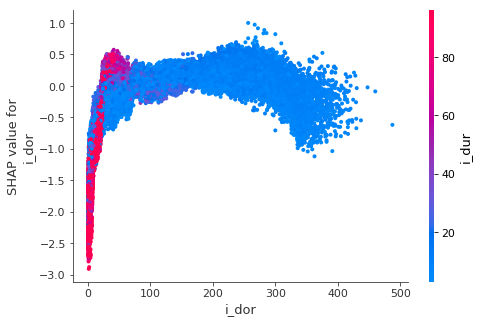

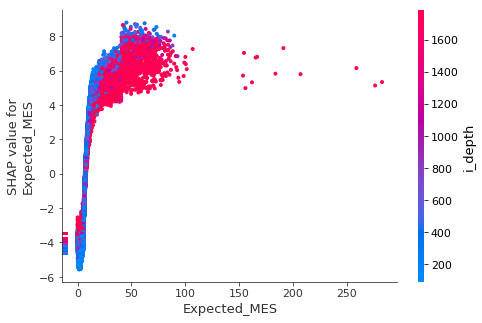

In [30]:
def getData(data, isSample, feat):
    if isSample:
        sample = df.sample(n=5000, random_state=1)
        sampledFeatures = sample[feat]
        recoverdMatrix = sample[['Recovered']].as_matrix()
        sampleRecovered = np.squeeze(np.asarray(recoverdMatrix))
        return sampledFeatures, sampleRecovered
    else:
        features = data[feat].to_pandas()
        recoveredMatrix = data[['Recovered']].to_pandas().as_matrix()
        recovered = np.squeeze(np.asarray(recoveredMatrix))
        return features, recovered

    
def shapAnalysis(originalX, model, features):
    explainer = shap.TreeExplainer(model=model, feature_dependence='tree_path_dependent', model_output='margin')
    shap_values = explainer.shap_values(X=originalX)
    shap.summary_plot(shap_values, originalX)
    shap.summary_plot(shap_values, originalX, plot_type="bar")
    for feature in features:
        shap.dependence_plot(ind=feature, shap_values=shap_values, features=originalX)
    

def fitCatBoost(X_train, y_train, X_validation, y_validation):
    model = CatBoostClassifier(
        n_estimators=1000,
        custom_loss=['Accuracy'],
        random_seed=42,
        logging_level='Silent'
    )
    model.fit(
        X_train, y_train,
        eval_set=(X_validation, y_validation),
        plot=True
    );
    
    
def analyze(feat, X, y):
    originalX, originalY = X, y
    X, X_test, y, y_test = train_test_split(originalX, originalY, train_size=0.80, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.90, random_state=42)
    
    fitCatBoost(X_train, y_train, X_validation, y_validation)
    shapAnalysis(originalX, model, feat)

feat = ['i_period', 'i_epoch', 'N_Transit', 'i_depth', 'i_dur', 'i_b', 'i_ror', 'i_dor', 'Expected_MES']
originalX, originalY = getData(raw_data, False, feat)
shap.initjs()
analyze(feat, originalX, originalY)

In [31]:
d = df.drop(df[df.i_dur < 15].index)
def getFeatures2(data, isSample, withMES):
    feat = ['i_period', 'i_epoch', 'N_Transit', 'i_depth', 'i_dur', 'i_b', 'i_ror', 'i_dor', 'Expected_MES'] if withMES else ['i_period', 'i_epoch', 'N_Transit', 'i_depth', 'i_dur', 'i_b', 'i_ror', 'i_dor']
    if isSample:
        sample = df.sample(n=5000, random_state=1)
        sampledFeatures = sample[feat]
        recoverdMatrix = sample[['Recovered']].as_matrix()
        sampleRecovered = np.squeeze(np.asarray(recoverdMatrix))
        return sampledFeatures, sampleRecovered
    else:
        features = data[feat]
        recoveredMatrix = data[['Recovered']].as_matrix()
        recovered = np.squeeze(np.asarray(recoveredMatrix))
        return features, recovered
def count(data):
    classifiedCount = 0
    unClassifiedCount = 0
    for item in data:
        if item == 1:
            classifiedCount += 1
        else:
            unClassifiedCount += 1
    return classifiedCount, unClassifiedCount


def recoveredProbabilityWithDuration(threashold):
    d = df.drop(df[df.i_dur < threashold].index) if threashold is not None else df

    classifiedCount, unClassifiedCount = count(d['Recovered'])

    return 100 * classifiedCount / (classifiedCount + unClassifiedCount)
    
    
def recoveredCatBoostWithDuration(threashold):
    d = df.drop(df[df.i_dur < threashold].index) if threashold is not None else df
    X, y = getFeatures2(d, False, True)
    y_pred = model.predict(X)
    classifiedCount, unClassifiedCount = count(y_pred)

    return 100 * classifiedCount / (classifiedCount + unClassifiedCount)

def recoveredProbabilityWithTransition(threashold):
    d = df.drop(df[df.N_Transit < threashold].index)
    classifiedCount, unClassifiedCount = count(d['Recovered'])
    return 100 * classifiedCount / (classifiedCount + unClassifiedCount)
    
    
def recoveredCatBoostWithTransition(threashold):
    d = df.drop(df[df.N_Transit < threashold].index)
    X, y = getFeatures2(d, False, True)
    y_pred = model.predict(X)
    classifiedCount, unClassifiedCount = count(y_pred)
    return 100 * classifiedCount / (classifiedCount + unClassifiedCount)

In [32]:
def getResult(testingLabel, y_pred):
    print("Accuracy:",metrics.accuracy_score(testingLabel, y_pred))
    print("Recall:",metrics.recall_score(testingLabel, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(testingLabel, y_pred)
    metrics.auc(fpr, tpr)
    print("AUC:", metrics.auc(fpr, tpr))
    print("F1 score:", metrics.f1_score(testingLabel, y_pred))

In [33]:
n = 15
print(recoveredProbabilityWithDuration(n))
print(recoveredCatBoostWithDuration(n))

17.631645409773963
16.67192827377194


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [34]:
thirty = 30
print(recoveredProbabilityWithDuration(thirty))
print(recoveredCatBoostWithDuration(thirty))

5.841429770900803
4.102195034184959


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


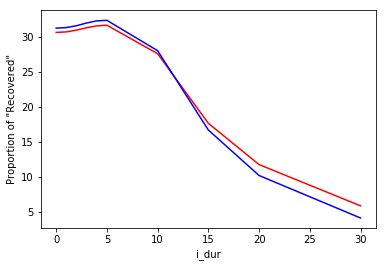

In [35]:
i_dur = [0,1,2,3,4,5,10,15,20, 30]
catBoost = []
rawData = []
for duration in i_dur:
    catBoost.append(recoveredProbabilityWithDuration(duration))
    rawData.append(recoveredCatBoostWithDuration(duration))
    
plt.plot(i_dur, catBoost, 'r-', label='CatBoost')
plt.plot(i_dur, rawData, 'b-', label = 'raw')
plt.xlabel('i_dur')
plt.ylabel('Proportion of "Recovered"')
plt.show()

In [38]:
thirty = 100
print(recoveredProbabilityWithTransition(thirty))
print(recoveredCatBoostWithTransition(thirty))

38.74589266155531
38.03395399780942


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


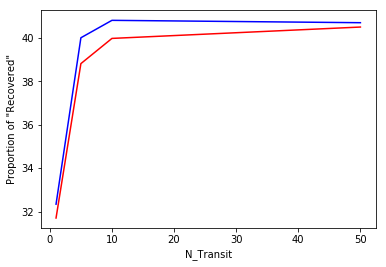

In [40]:
N_Transition = [1,5,10,50]
catBoost = []
rawData = []
for transit in N_Transition:
    catBoost.append(recoveredProbabilityWithTransition(transit))
    rawData.append(recoveredCatBoostWithTransition(transit))
    
plt.plot(N_Transition, catBoost, 'r-', label='CatBoost')
plt.plot(N_Transition, rawData, 'b-', label = 'raw')
plt.xlabel('N_Transit')
plt.ylabel('Proportion of "Recovered"')
plt.show()